In [1]:
using LinearAlgebra, Plots, CSV, Tables
# 函数定义
@inline function get_Phi(q)
    return [q[5]*cos(q[2]) - q[3] + cos(q[4]);
    q[1] + q[5]*sin(q[2]) + sin(q[4])]
end

@inline function get_Psi(y, q)
    return [q[3] - y[1];
    q[1] - y[2];
    q[5] - y[3]]
end

@inline function get_Gamma(q, z)
    return [2*cos(q[2]) - z[1];
    q[1] + 2*sin(q[2]) - z[2]]
end

@inline function get_y(q)
    return [q[3]; q[1]; q[5]]
end

@inline function get_z(q)
    return [2*cos(q[2]); q[1] + 2*sin(q[2])]
end

@inline function get_Omega(y, q)
    return [get_Phi(q); get_Psi(y, q)]
end

@inline function get_Lambda(q, z)
    return [get_Phi(q); get_Gamma(q, z)]
end

@inline function get_Omegaq(q)
    return [0 -q[5]*sin(q[2]) -1 -sin(q[4]) cos(q[2]);
    1 q[5]*cos(q[2]) 0 cos(q[4]) sin(q[2]);
    0 0 1 0 0;
    1 0 0 0 0;
    0 0 0 0 1]
end

@inline function get_Lambdaq(q)
    return [0 -q[5]*sin(q[2]) -1 -sin(q[4]) cos(q[2]);
    1 q[5]*cos(q[2]) 0 cos(q[4]) sin(q[2]);
    0 -2*sin(q[2]) 0 0 0;
    1 2*cos(q[2]) 0 0 0]
end

function f_Kine(y)
    q = [1; 0; 1; -pi/2; 1]
    Omega = get_Omega(y, q)
    while norm(Omega) > 1e-5
        q = q - get_Omegaq(q)\Omega
        Omega = get_Omega(y, q)
    end
    return q
end

function comp_u(q0, U, V, B, u, v, z, utol)
    gamma = get_Lambda(q0 + V*v - U*u, z)
    while norm(gamma) > utol
        u = u + B*gamma
        gamma = get_Lambda(q0 + V*v - U*u, z)
    end
    return u
end

function comp_B(q, U, B, Btol)
    upsilon = get_Lambdaq(q)*U*B
    while norm(upsilon - I(size(upsilon, 1))) > Btol
        B = 2*B - B*upsilon
        upsilon = get_Lambdaq(q)*U*B
    end
    return B
end

comp_B (generic function with 1 method)

In [2]:
# 参数设置
utol = 1e-7
Btol = 1e-7
h = 1e-3
tList = collect(0:h:1)
zList = zeros((2, length(tList)))
qList = zeros((5, length(tList)))
yList = zeros((3, length(tList)))
y0 = [1.5; 0.2; 1]
path = "inputTraj.csv"

"inputTraj.csv"

In [3]:
# 初始化
q0 = f_Kine(y0)
q = deepcopy(q0)
U = get_Lambdaq(q0)'
V = nullspace(U')
B = inv(U'*U)
u = -U'*(q - q0)
v = V'*(q - q0)
z0 = get_z(q)
zList[:, 1] = deepcopy(z0)
qList[:, 1] = deepcopy(q)
yList[:, 1] = deepcopy(y0)

3-element Vector{Float64}:
 1.5
 0.2
 1.0

In [4]:
# 迭代计算
for t = 2:length(tList)
    z = z0 + [0.1*cos(2*pi/1000*t) - 0.1; 0.1*sin(2*pi/1000*t)]
    # z = z0
    # v = t*h
    v = 0.5sin(pi*tList[t])

    B = comp_B(q, U, B, Btol)
    u = comp_u(q0, U, V, B, u, v, z, utol)
    q = q0 + V*v - U*u

    qList[:, t] = deepcopy(q)
    zList[:, t] = get_z(q)
    yList[:, t] = get_y(q)
end
CSV.write(path, Tables.table(yList'), writeheader=false)

"inputTraj.csv"

┌ Info: Saved animation to c:\Users\17739\Git\Kinematics-Dynamics\Computer-aided Kinematics and Dynamics-Haug\src\9.16-anim1.gif
└ @ Plots C:\Users\17739\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\17739\\Git\\Kinematics-Dynamics\\Computer-aided Kinematics and Dynamics-Haug\\src\\9.16-anim1.gif")
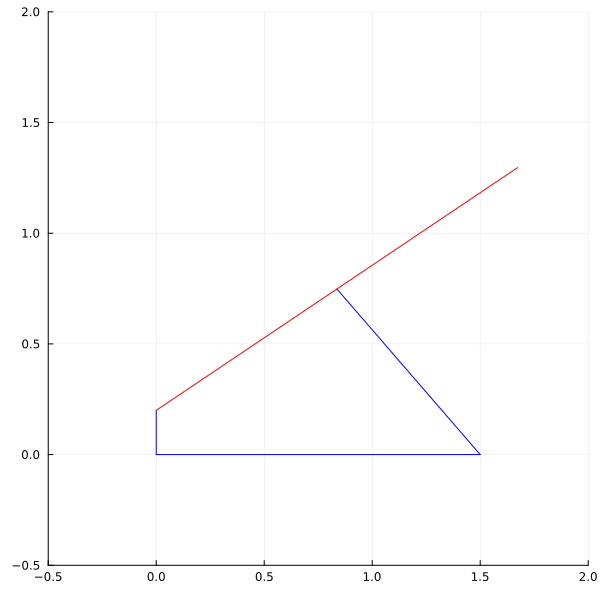

In [5]:
# 动画
anim = @animate for t in 1:length(tList)
    plot([qList[3, t]; qList[3, t] - cos(qList[4, t])], [0; sin(-qList[4, t])], xlim=(-0.5, 2), ylim=(-0.5, 2), size = (600, 600), label = "", color = :blue)
    plot!([0; 0], [0; qList[1, t]], label = "", color = :blue)
    plot!([0; qList[3, t]], [0; 0], label = "", color = :blue)
    plot!([0; 2*cos(qList[2, t])], [qList[1, t]; qList[1, t] + 2*sin(qList[2, t])], label = "", color = :red)
    plot!(zList[1, 1:t], zList[2, 1:t], label = "")
end

gif(anim, "9.16-anim1.gif", fps = 50)